# Explainer Jupyter Notebook
### A Copenhagen Data Story - Inequality in Health and Wealth
Technical University of Denmark

02806 Social Data Analysis and Visualization

May 12, 2023
* Søren Blatt Bendtsen - s164521
* Vivién Varadi - s222737
* Thomas Adamopoulos -s213163

# 1. Motivation

As also mentioned in the article, our motivation to deap dive further into health and wealth in Copenhagen came from discussions on different views on life in Copenhagen. We were very motivated to look further into actual topics that we notice in our everyday life of living in Copenhagen. 

We have gathered our data set from the tool Velstand & Ulighed created by Rockwool Fonden. Rockwool Fonden uses data delivered by Danmark Statistik (DST) from their administrative register. The underlying data is therefore row based on individual people living in Denmark identifiable by their CPR-number [1]. The data publicly available to download from Rockwool Fonden's tool is aggregated on a yearly base for groups of the population.

First of all, as this project is for the class "Social Data Analysis and Visualization", we wanted to have a social aspect on the project. And working with inequality has just that. Second of all, we chose to work with this specific data set as it has several interesting continous numerical attributes, as well as interesting demographic categorical attributes, that we imagined to find interesting trends within. We decided to work with the 20 municipalities located in the greater region of Copenhagen, as well as an average for the whole of Denmark.

Our goal with this project was to bring facts into a discussion that is very often based on assumptions, opinions and what you are used to hearing in the news. We, among ourselves in the group, had discussions based on experience, and we believed that looking at the actual data within these topics, would bring a deeper dimension to our discussion. For the end user of the article, we wanted to create an article with interactive visualizations, where we would highlight the most important aspects, but that at the same time would allow the user dig down even further in the data.

# 2. Basic stats and data preparation

### 2.1 Data preparation
Quite a lot of data preparation and cleaning was required to create the final data set that we have worked on. This work has been done in four separate Jupyter Notebooks, as it required many lines of code. Among other things, the following have been done.

* From the tool Velstand & Ulighed, we decided to download data sets for disposable income, number of days spent in the hospital and number of hospitalizations. Only small chunks of data could be downloaded at the time for small group of years, municipalities, ages, genders, educations and ethnicities and therefore many small data sets had to be merged together.
* When downloading the data sets, the demographic variables were not named. This therefore had to be done for each small data set before merging them together.
* Remove duplicates. Every chunk of data included an average for the total Denmark. Duplicates of this have been moved.
* Translation from Danish to English
* Matching of municipality code to actual municipality name
* Weighted calculations: as the data is on an aggregated basis, we had to use the number of observations (included from Velstand & Ulighed) within each group in order to calculate a variety of weighted numbers, that can then be used when grouping by a combination of different variables.
* Calculate Greater Copenhagen average. We wanted to compare the whole of Denmark to Copenhagen. For that reason we have calculated weighted averages for the Greater Copenhagen Region based on data from the 20 municipalities within Copenhagen.
* Select relevant columns

After doing the above work for the data sets related to Income, Days in Hospital and Number of Hospitalizations, they have at last been merged together to one complete data set called copenhagen_data.csv.

In [1]:
# import libraries
# Used for working with dataframes, visualizing data and doing machine learning
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objs as go
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split


from sklearn.model_selection import cross_val_score, GridSearchCV, KFold
from sklearn.linear_model import LinearRegression, Ridge
from scipy import stats
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

In [2]:
# Load data set and save to data frame
df = pd.read_csv('copenhagen_data.csv')

At this point, we realized that there was many rows with Null Values. This was due to the data for Income, Days in Hospital and Number of Hospitalizations not being available for the same number of years and demographic groups. For that reason we are dropping missing values below.

In [3]:
# Drop rows with missing values
df_2= df.dropna()
# Create separated data frames for Denmark, Greater Copenhagen and Copenhagen municipalities
df_dk = df_2[df_2.municipality == 'Denmark']
df_cph = df_2[df_2.municipality == 'Greater Copenhagen']
df_cph_mun = df_2[(df_2.municipality != 'Denmark') & (df_2.municipality != 'Greater Copenhagen')] # Greater Copenhagen municipalities

### 2.2 Exploratory data analysis
So let's understand the data set a bit further. We will look at the following:
* Basic stats, number of rows and columns
* Distribution of number of observations
* Distribution of Income, Days in Hospital and Number of Hospitalizations

In [4]:
# Number of columns and rows in data frame
print(df_2.shape)

# Print column names
print(df_2.columns)

(11320, 28)
Index(['municipality', 'municipality code', 'year', 'gender', 'age',
       'ethnicity', 'education', 'income', 'income observations',
       'weighted_inc_mun', 'weighted_inc_gen_mun', 'weighted_inc_age_mun',
       'weighted_inc_eth_mun', 'weighted_inc_edu_mun', 'days in hospital',
       'days in hospital observations', 'weighted_hosp_days_mun',
       'weighted_days_gen_mun', 'weighted_days_age_mun',
       'weighted_days_eth_mun', 'weighted_days_edu_mun',
       'number of hospitalizations', 'number of hospitalizations observations',
       'weighted_hospitalizations_mun', 'weighted_hosp_gen_mun',
       'weighted_hosp_age_mun', 'weighted_hosp_eth_mun',
       'weighted_hosp_edu_mun'],
      dtype='object')


After dropping the NaN values, we ended up having 11320 observations that we could work with, which is still more than enough. We also have 28 columns, where 14 of them are additional columns with weighted values that we have calculated.


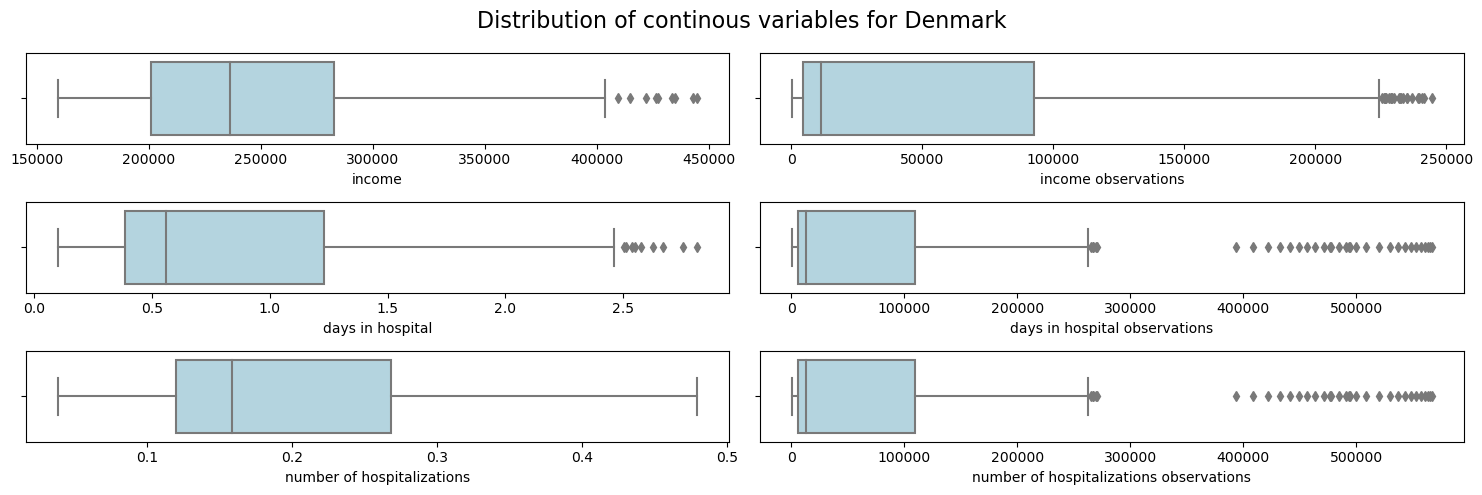

In [5]:
# Disitribution of data for Denmark

# Create a figure with boxlots for income, income observations, days in hospital, days in hospital observations, number of hospitalizations and number of hospitalizations observations
fig, axes = plt.subplots(3, 2, figsize=(15, 5))
sns.boxplot(ax=axes[0, 0], data=df_dk, x='income', color='lightblue')
sns.boxplot(ax=axes[0, 1], data=df_dk, x='income observations', color='lightblue')
sns.boxplot(ax=axes[1, 0], data=df_dk, x='days in hospital', color='lightblue')
sns.boxplot(ax=axes[1, 1], data=df_dk, x='days in hospital observations', color='lightblue')
sns.boxplot(ax=axes[2, 0], data=df_dk, x='number of hospitalizations', color='lightblue')
sns.boxplot(ax=axes[2, 1], data=df_dk, x='number of hospitalizations observations', color='lightblue')
fig.suptitle('Distribution of continous variables for Denmark', fontsize=16)
plt.tight_layout()
plt.show()

When looking at the whole of Denmark, we see the groups of people (rows of data) have a large range in number of observations. For income a few groups include more than 200,000 observations, but the majority lie somewhere between 10,000 and 90,000 observations. For the health variables, the number of observations are much higher with several outliers going above 400,000 and even 500,000 observations. The reason for the different sizes are explained in the documentation of the tool Vestland & Ulighed [1].

Of the country average, we see the lowest annual disposable income of around 160,000 DKK and the highest of around 440,000 DKK, with the majority lying between 200,000 and 275,000. 

For the health variables, the tail is also longer towards the right. So for income, we see a larger gap between the very rich and the average, and for the health variables we see a larger gap between those who spent most time in the hospital than the average.

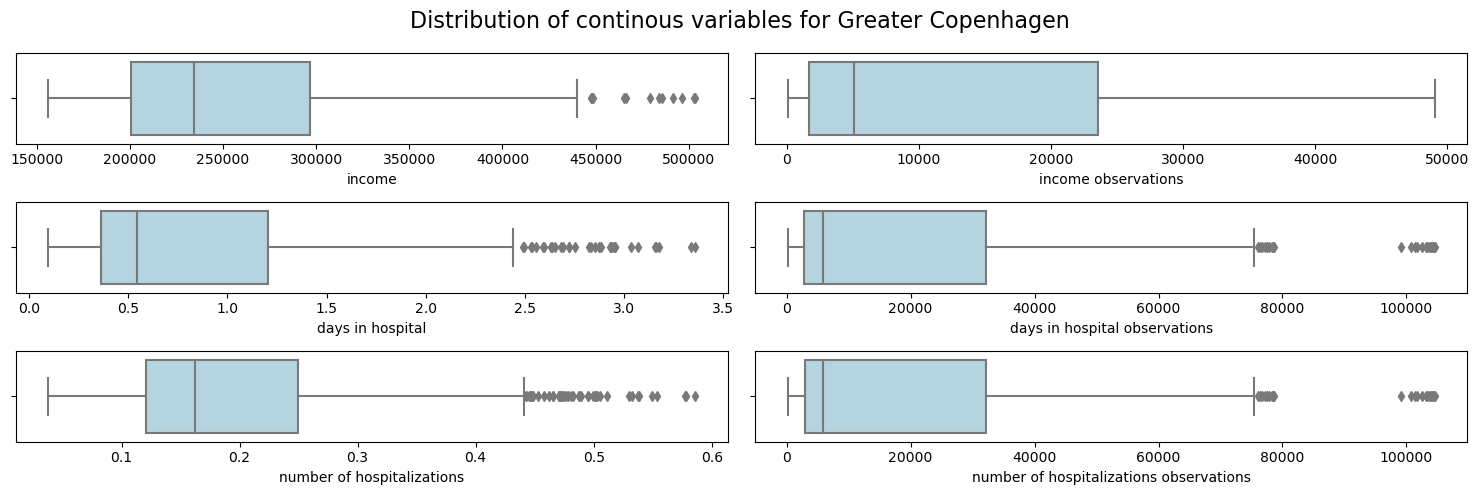

In [6]:
# Disitribution of data for Greater Copenhagen

# Create a figure with boxlots for income, income observations, days in hospital, days in hospital observations, number of hospitalizations and number of hospitalizations observations
fig, axes = plt.subplots(3, 2, figsize=(15, 5))
sns.boxplot(ax=axes[0, 0], data=df_cph, x='income', color='lightblue')
sns.boxplot(ax=axes[0, 1], data=df_cph, x='income observations', color='lightblue')
sns.boxplot(ax=axes[1, 0], data=df_cph, x='days in hospital', color='lightblue')
sns.boxplot(ax=axes[1, 1], data=df_cph, x='days in hospital observations', color='lightblue')
sns.boxplot(ax=axes[2, 0], data=df_cph, x='number of hospitalizations', color='lightblue')
sns.boxplot(ax=axes[2, 1], data=df_cph, x='number of hospitalizations observations', color='lightblue')
fig.suptitle('Distribution of continous variables for Greater Copenhagen', fontsize=16)
plt.tight_layout()
plt.show()

For the Greater Copenhagen, the number of observations are much fewer of course, as we are looking at a subset of the whole of Denmark. There are also more observations for the health variables.

The majority of income lies between 200,000 and 300,000 observations, but with a longer tail of groups with a high income. At the same time, the tail to the right for the health variables is longer with some groups spending more time in the hospital.

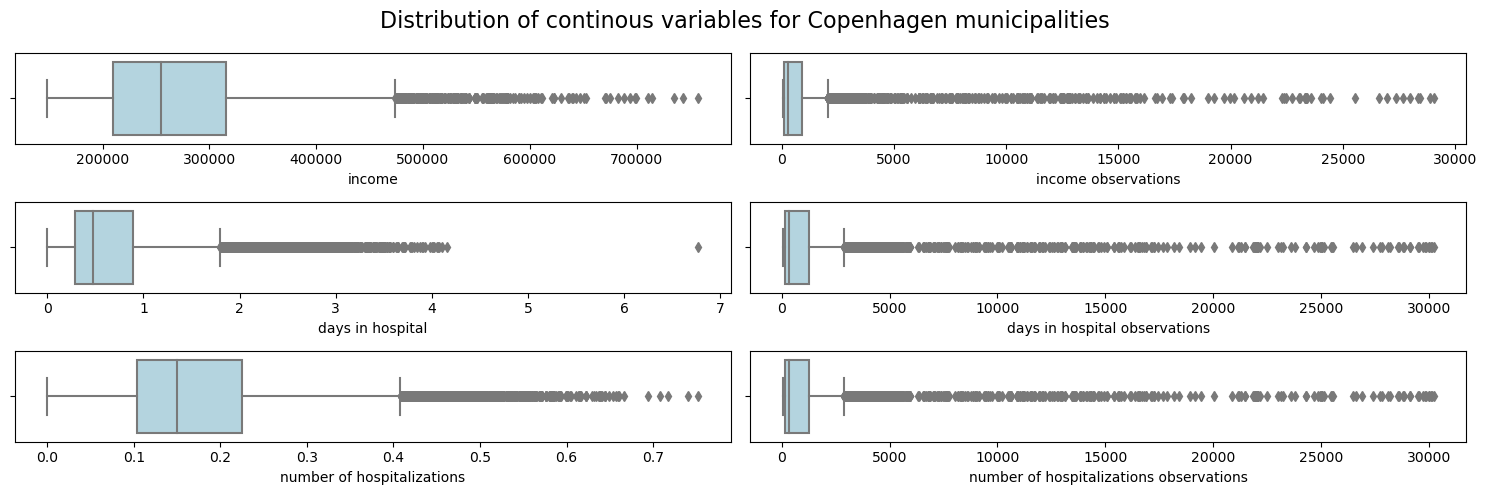

In [7]:
# Disitribution of data for Copenhagen Municipalities

# Create a figure with boxlots for income, income observations, days in hospital, days in hospital observations, number of hospitalizations and number of hospitalizations observations
fig, axes = plt.subplots(3, 2, figsize=(15, 5))
sns.boxplot(ax=axes[0, 0], data=df_cph_mun, x='income', color='lightblue')
sns.boxplot(ax=axes[0, 1], data=df_cph_mun, x='income observations', color='lightblue')
sns.boxplot(ax=axes[1, 0], data=df_cph_mun, x='days in hospital', color='lightblue')
sns.boxplot(ax=axes[1, 1], data=df_cph_mun, x='days in hospital observations', color='lightblue')
sns.boxplot(ax=axes[2, 0], data=df_cph_mun, x='number of hospitalizations', color='lightblue')
sns.boxplot(ax=axes[2, 1], data=df_cph_mun, x='number of hospitalizations observations', color='lightblue')
fig.suptitle('Distribution of continous variables for Copenhagen municipalities', fontsize=16)
plt.tight_layout()
plt.show()

When looking inside the 20 municipalities of Copenhagen, there are ofcourse a very large distribution on the observations, as all the municipalities are not of the same size.

However, there is also a much wider distribution between the wealthiest groups and middle income groups. This is also the case for the health variables, that the people spending most time in the hospital are spending much more time than the average.

For the Days in Hospital, there looks to be one special outlier, with one group spending on average almost 7 days in the per year. 

# 3. Data analysis

## K-means Clustering

In [8]:
# Load data set and save to data frame
df = pd.read_csv('copenhagen_data.csv')

In [9]:
# Drop rows with missing values
df_cluster= df.dropna()

In [10]:
# Pick observation only for Denamrk and Copenhagen
df_cluster = df_cluster[(df_cluster.municipality == 'Denmark') | (df_cluster.municipality == 'Greater Copenhagen')]

In [11]:
# # Perform one-hot encoding on the relevant columns
one_hot_encoded_municipality = pd.get_dummies(df_cluster.municipality, prefix='municipality')
one_hot_encoded_gender = pd.get_dummies(df_cluster.gender, prefix='gender')
one_hot_encoded_ethnicity = pd.get_dummies(df_cluster.ethnicity, prefix='ethnicity')
one_hot_encoded_age = pd.get_dummies(df_cluster.age, prefix='age')
one_hot_encoded_education = pd.get_dummies(df_cluster.education, prefix='education')

In [12]:
# # Concatenate the one-hot encoded columns to the original DataFrame
df_cluster = pd.concat([df_cluster.drop('municipality', axis=1), one_hot_encoded_municipality], axis=1)
df_cluster = pd.concat([df_cluster.drop('gender', axis=1), one_hot_encoded_gender], axis=1)
df_cluster = pd.concat([df_cluster.drop('ethnicity', axis=1), one_hot_encoded_ethnicity], axis=1)
df_cluster = pd.concat([df_cluster.drop('age', axis=1), one_hot_encoded_age], axis=1)
df_cluster = pd.concat([df_cluster.drop('education', axis=1), one_hot_encoded_education], axis=1)


data_encoded = ['municipality_Denmark', 'municipality_Greater Copenhagen' ]


df_cluster.head()
df_cluster.shape
# df_cluster.columns
# df.head()
# df.shape

(1372, 36)

In [13]:
df_cluster = df_cluster.drop(['year', 'municipality code', 'income observations', 'weighted_inc_mun', 'weighted_inc_gen_mun', 'weighted_inc_age_mun', 'weighted_inc_eth_mun',
       'weighted_inc_edu_mun', 'days in hospital observations','weighted_hosp_days_mun', 'weighted_days_gen_mun', 'weighted_days_age_mun', 'weighted_days_eth_mun', 
       'weighted_days_edu_mun', 'number of hospitalizations', 'number of hospitalizations observations',  'weighted_hospitalizations_mun', 'weighted_hosp_gen_mun',
       'weighted_hosp_age_mun', 'weighted_hosp_eth_mun', 'weighted_hosp_edu_mun'], axis=1)
df_cluster.columns

Index(['income', 'days in hospital', 'municipality_Denmark',
       'municipality_Greater Copenhagen', 'gender_Men', 'gender_Women',
       'ethnicity_Danish', 'ethnicity_Immigrants and descendants',
       'ethnicity_Non-western immigrants and descendants', 'age_30-39',
       'age_40-49', 'age_50-59', 'age_60-65', 'education_Higher education',
       'education_No higher education'],
      dtype='object')

In [14]:
# Standardize data, including numerical variables. This step is important for K-Means because it relies on distance measures:

scaler = StandardScaler()
data_scaled = scaler.fit_transform(df_cluster)

/var/folders/h6/f8twklt56rdg96n68wjjppdm0000gn/T/ipykernel_89343/2260009517.py:12: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bx-" (-> color='b'). The keyword argument will take precedence.
  plt.plot(K, inertias, 'bx-', color = 'orange')


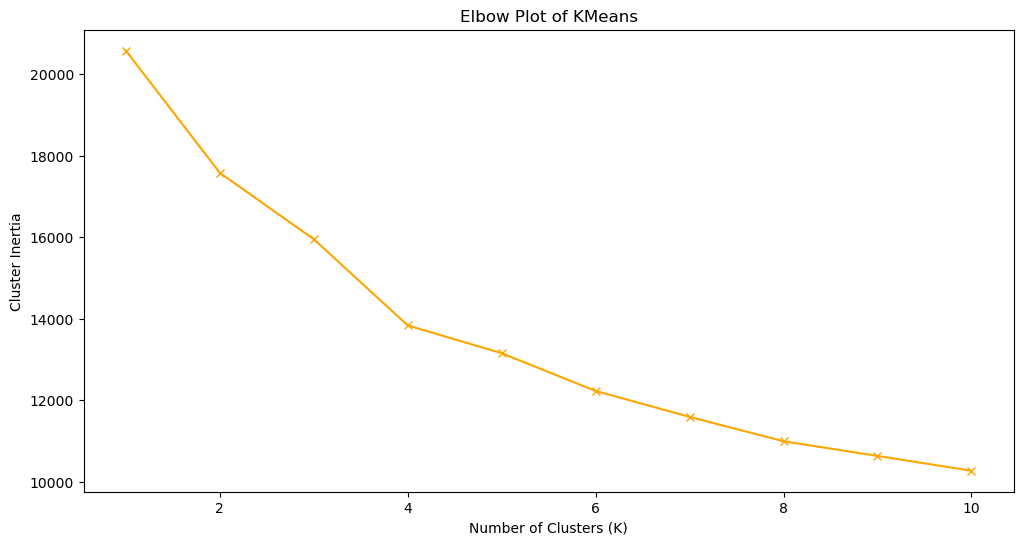

In [15]:
inertias = []
K = range(1, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_scaled)
    inertias.append(kmeans.inertia_)

# Plotting the results
figure = plt.subplots(figsize = (12, 6))

plt.plot(K, inertias, 'bx-', color = 'orange')
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Cluster Inertia")
plt.title("Elbow Plot of KMeans")
plt.show()

In [16]:
k = 4  # Choose an appropriate value based on the elbow plot
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(data_scaled)

KMeans(n_clusters=4, random_state=42)

In [17]:
df_cluster['cluster'] = kmeans.labels_
df_cluster.head()

,income,days in hospital,municipality_Denmark,municipality_Greater Copenhagen,gender_Men,gender_Women,ethnicity_Danish,ethnicity_Immigrants and descendants,ethnicity_Non-western immigrants and descendants,age_30-39,age_40-49,age_50-59,age_60-65,education_Higher education,education_No higher education,cluster
6,271510.362,0.215,1,0,1,0,1,0,0,1,0,0,0,1,0,2
7,218419.246,0.386,1,0,1,0,1,0,0,1,0,0,0,0,1,2
8,220190.110,0.202,1,0,1,0,0,1,0,1,0,0,0,1,0,2
9,169031.486,0.359,1,0,1,0,0,1,0,1,0,0,0,0,1,2
10,190374.958,0.266,1,0,1,0,0,0,1,1,0,0,0,1,0,2


In [18]:
cluster_sizes = df_cluster['cluster'].value_counts()
print(cluster_sizes)

0    364
2    336
1    336
3    336
Name: cluster, dtype: int64


In [19]:
# Create a DataFrame with the scaled data
data_scaled_df = pd.DataFrame(df_cluster, columns=df_cluster.columns)

# Add the cluster labels
data_scaled_df['cluster'] = kmeans.labels_

# Calculate the cluster centroids in the scaled data
centroids_scaled = data_scaled_df.groupby('cluster').mean().reset_index()

# Transform the centroids back to the original data scale
centroids = scaler.inverse_transform(centroids_scaled.drop('cluster', axis=1))

# Create a DataFrame with the original-scale centroids
centroids_df = pd.DataFrame(centroids, columns=df_cluster.columns[:-1])
print(centroids_df)

         income  days in hospital  municipality_Denmark  \
0  1.700749e+10          2.149398              0.779379   
1  1.631308e+10          1.144579              0.760152   
2  1.441815e+10          1.087732              0.760152   
3  1.750212e+10          1.334736              0.760152   

   municipality_Greater Copenhagen  gender_Men  gender_Women  \
0                         0.720517    0.779379      0.720517   
1                         0.739744    0.760152      0.739744   
2                         0.739744    0.760152      0.739744   
3                         0.739744    0.760152      0.739744   

   ethnicity_Danish  ethnicity_Immigrants and descendants  \
0          0.470821                              0.470821   
1          0.482845                              0.482845   
2          0.482845                              0.482845   
3          0.482845                              0.482845   

   ethnicity_Non-western immigrants and descendants  age_30-39  age_40-49  \


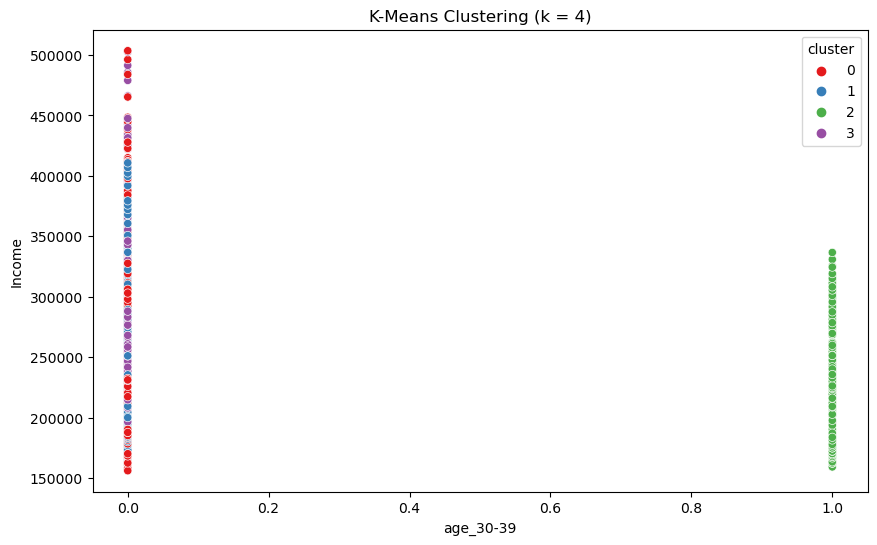

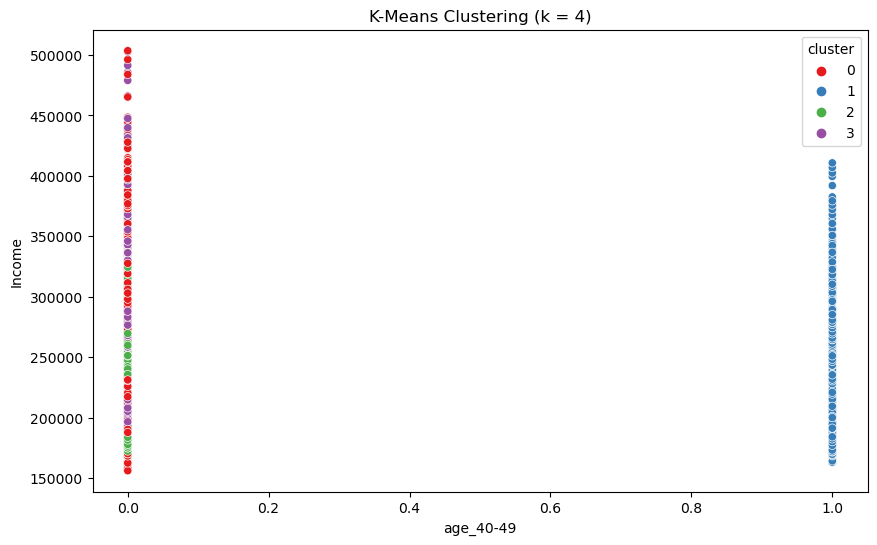

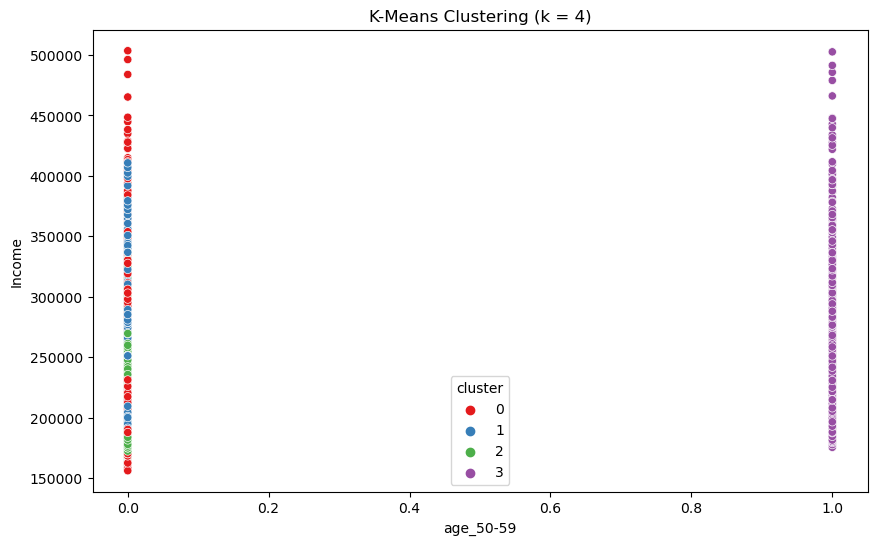

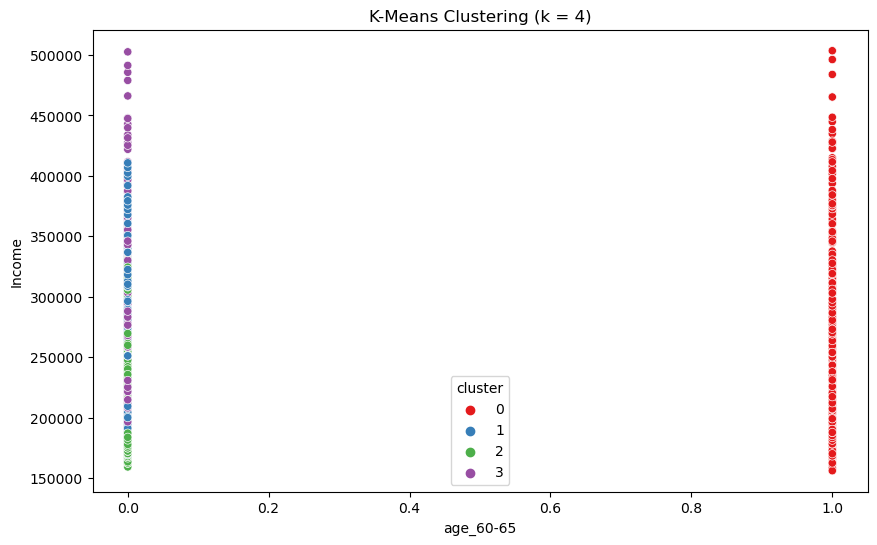

In [20]:
# Create a list of age group column names to loop through
age_cols = ['age_30-39', 'age_40-49', 'age_50-59', 'age_60-65']

# Loop through the age group columns and create scatter plots for each one
for age_col in age_cols:
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=age_col, y='income', hue='cluster', data=df_cluster, palette='Set1')
    plt.xlabel(age_col)
    plt.ylabel('Income')
    plt.title('K-Means Clustering (k = {})'.format(k))
    plt.show()

In [21]:
# Calculate the cluster centroids in the scaled data
centroids_scaled = data_scaled_df.groupby('cluster').mean().reset_index()

# Transform the centroids back to the original data scale
centroids = scaler.inverse_transform(centroids_scaled.drop('cluster', axis=1))

# Create a DataFrame with the original-scale centroids
centroids_df = pd.DataFrame(centroids, columns=df_cluster.columns[:-1])
print(centroids_df)

         income  days in hospital  municipality_Denmark  \
0  1.700749e+10          2.149398              0.779379   
1  1.631308e+10          1.144579              0.760152   
2  1.441815e+10          1.087732              0.760152   
3  1.750212e+10          1.334736              0.760152   

   municipality_Greater Copenhagen  gender_Men  gender_Women  \
0                         0.720517    0.779379      0.720517   
1                         0.739744    0.760152      0.739744   
2                         0.739744    0.760152      0.739744   
3                         0.739744    0.760152      0.739744   

   ethnicity_Danish  ethnicity_Immigrants and descendants  \
0          0.470821                              0.470821   
1          0.482845                              0.482845   
2          0.482845                              0.482845   
3          0.482845                              0.482845   

   ethnicity_Non-western immigrants and descendants  age_30-39  age_40-49  \


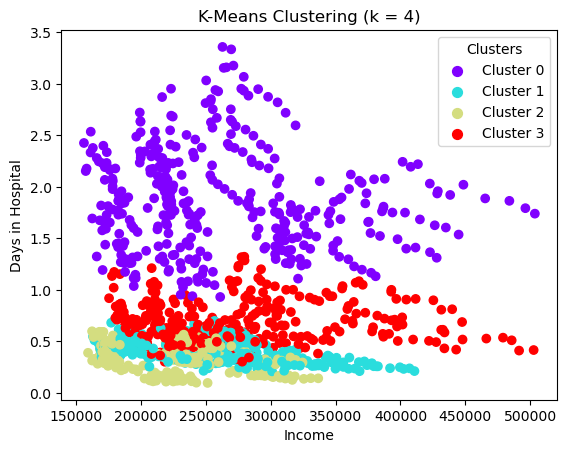

In [22]:
# Create a dictionary that maps each cluster label to a unique color
colors = cm.rainbow(np.linspace(0, 1, k))
color_dict = {i: colors[i] for i in range(k)}

# Plot the scatter plot with color and cluster labels
plt.scatter(df_cluster["income"], df_cluster["days in hospital"], c=df_cluster["cluster"], cmap=cm.rainbow)
plt.xlabel("Income")
plt.ylabel("Days in Hospital")
plt.title("K-Means Clustering (k = {})".format(k))

# Add a legend with color and cluster labels
legend_elements = [plt.scatter([], [], marker="o", s=50, color=color_dict[i], label="Cluster {}".format(i)) for i in range(k)]
plt.legend(handles=legend_elements, title="Clusters")

# # Add cluster labels
# for i, row in df_cluster.iterrows():
#     plt.text(row["income"], row["days in hospital"], str(row["cluster"]), color="black")

plt.show()

## Linear Regression 

In [23]:
# Drop rows with missing values
df_reg = df.dropna()
df_reg.head()
# df_reg.shape

,municipality,municipality code,year,gender,age,ethnicity,education,income,income observations,weighted_inc_mun,...,weighted_days_age_mun,weighted_days_eth_mun,weighted_days_edu_mun,number of hospitalizations,number of hospitalizations observations,weighted_hospitalizations_mun,weighted_hosp_gen_mun,weighted_hosp_age_mun,weighted_hosp_eth_mun,weighted_hosp_edu_mun
6,Denmark,0,2005,Men,30-39,Danish,Higher education,271510.362,98566.0,10707.481497,...,0.028632,0.005907,0.023621,0.056,103551.0,0.001415,0.002864,0.007458,0.001539,0.006177
7,Denmark,0,2005,Men,30-39,Danish,No higher education,218419.246,229065.0,20018.126583,...,0.123671,0.025516,0.030419,0.096,249125.0,0.005835,0.011811,0.030758,0.006346,0.007568
8,Denmark,0,2005,Men,30-39,Immigrants and descendants,Higher education,220190.110,5813.0,512.120219,...,0.001691,0.006485,0.001395,0.062,6508.0,0.000098,0.000199,0.000519,0.001990,0.000430
9,Denmark,0,2005,Men,30-39,Immigrants and descendants,No higher education,169031.486,14256.0,964.137750,...,0.007378,0.028302,0.001815,0.094,15981.0,0.000366,0.000742,0.001932,0.007411,0.000475
10,Denmark,0,2005,Men,30-39,Non-western immigrants and descendants,Higher education,190374.958,3201.0,243.819977,...,0.001208,0.007099,0.000997,0.079,3532.0,0.000068,0.000138,0.000359,0.002188,0.000297


In [24]:
ordinal_enc = OrdinalEncoder()
label_enc = LabelEncoder()

# apply ordinal encoding to age
df_reg['age'] = ordinal_enc.fit_transform(df_reg[['age']])

# apply label encoding to education
df_reg['education'] = label_enc.fit_transform(df_reg['education'])

# apply one-hot encoding to gender and ethnicity
df_reg = pd.get_dummies(df_reg, columns=['gender', 'ethnicity', 'municipality'])


/var/folders/h6/f8twklt56rdg96n68wjjppdm0000gn/T/ipykernel_89343/4203430452.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_reg['age'] = ordinal_enc.fit_transform(df_reg[['age']])
/var/folders/h6/f8twklt56rdg96n68wjjppdm0000gn/T/ipykernel_89343/4203430452.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_reg['education'] = label_enc.fit_transform(df_reg['education'])


In [25]:
# Define our features and target variable
X = df_reg[['income', 'age', 'education', 'gender_Men', 'gender_Women',
            'ethnicity_Danish', 'ethnicity_Immigrants and descendants',
            'ethnicity_Non-western immigrants and descendants',
            'municipality_Albertslund', 'municipality_Ballerup',
            'municipality_Brøndby', 'municipality_Copenhagen',
            'municipality_Denmark', 'municipality_Dragør',
            'municipality_Frederiksberg', 'municipality_Furesø',
            'municipality_Gentofte', 'municipality_Gladsaxe',
            'municipality_Glostrup', 'municipality_Greater Copenhagen',
            'municipality_Greve', 'municipality_Herlev', 'municipality_Hvidovre',
            'municipality_Høje-Taastrup', 'municipality_Ishøj',
            'municipality_Lyngby-Taarbæk', 'municipality_Rudersdal',
            'municipality_Rødovre', 'municipality_Tårnby',
            'municipality_Vallensbæk']]
y = df_reg['days in hospital']

In [26]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [27]:
# Initialize GridSearchCV for Ridge Regression
grid = GridSearchCV(estimator=Ridge(), param_grid={'alpha': [0.1, 1, 10]}, cv=10, scoring='neg_mean_squared_error')

In [28]:
# Fit on the training data
grid.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=Ridge(), param_grid={'alpha': [0.1, 1, 10]},
             scoring='neg_mean_squared_error')

In [29]:
# Get the best alpha
best_alpha = grid.best_params_['alpha']

In [30]:
model = Ridge(alpha=best_alpha)

# Define the models and their hyperparameters
models_and_parameters = {
    'linear_regression': {
        'model': LinearRegression(),
        'params': {}
    },
    'ridge_regression': {
        'model': Ridge(),
        'params': {'alpha': [0.1, 1, 10]}
    },
    'polynomial_regression_degree_2': {
        'model': make_pipeline(PolynomialFeatures(2), LinearRegression()),
        'params': {}
    }
}

In [31]:
# Initialize KFold for outer loop
outer_cv = KFold(n_splits=10, shuffle=True, random_state=42)

# Loop over the models
for model_name, model_info in models_and_parameters.items():
    # Initialize GridSearchCV for inner loop
    grid = GridSearchCV(estimator=model_info['model'], param_grid=model_info['params'], cv=10, scoring='neg_mean_squared_error')

    # Fit and predict on the outer loop, then take the negative mean squared error
    nested_score = cross_val_score(grid, X=X_train, y=y_train, cv=outer_cv, scoring='neg_mean_squared_error')

    # Print the model's mean MSE and standard deviation
    print(f'{model_name}: Mean MSE: {-nested_score.mean()}, Standard deviation: {nested_score.std()}')

linear_regression: Mean MSE: 0.2179108656434698, Standard deviation: 0.018650173067757247
ridge_regression: Mean MSE: 0.21788108328496075, Standard deviation: 0.018628350012267546
polynomial_regression_degree_2: Mean MSE: 0.09504752330956028, Standard deviation: 0.018356021361190716


In [32]:
# Define the models
models = {
    'linear_regression': LinearRegression(),
    'ridge_regression': Ridge(alpha=best_alpha),
    'polynomial_regression_degree_2': make_pipeline(PolynomialFeatures(2), LinearRegression())
}


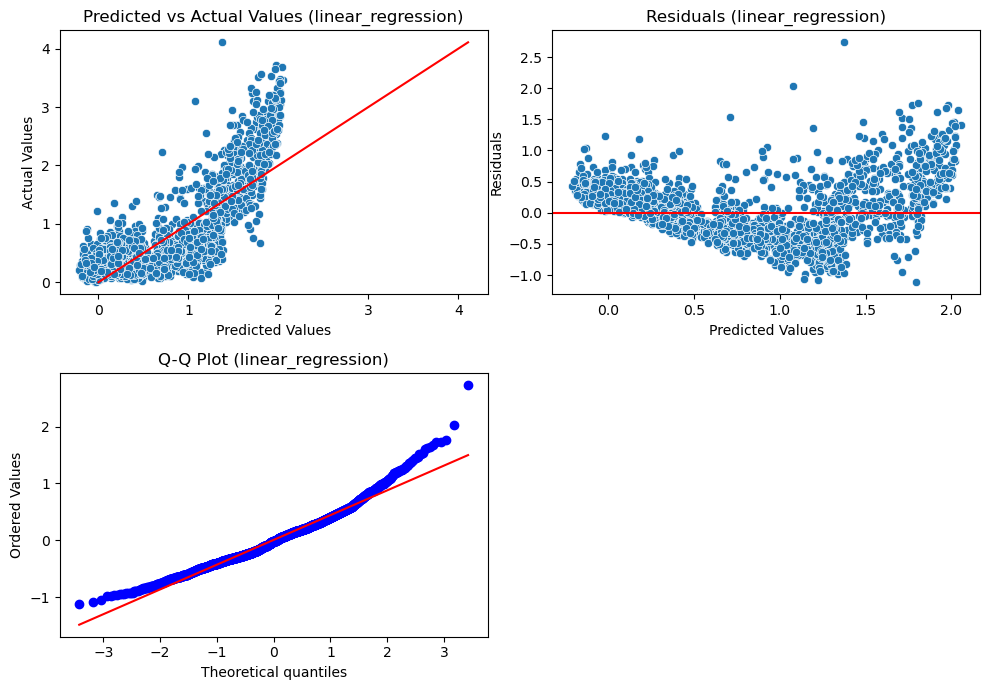

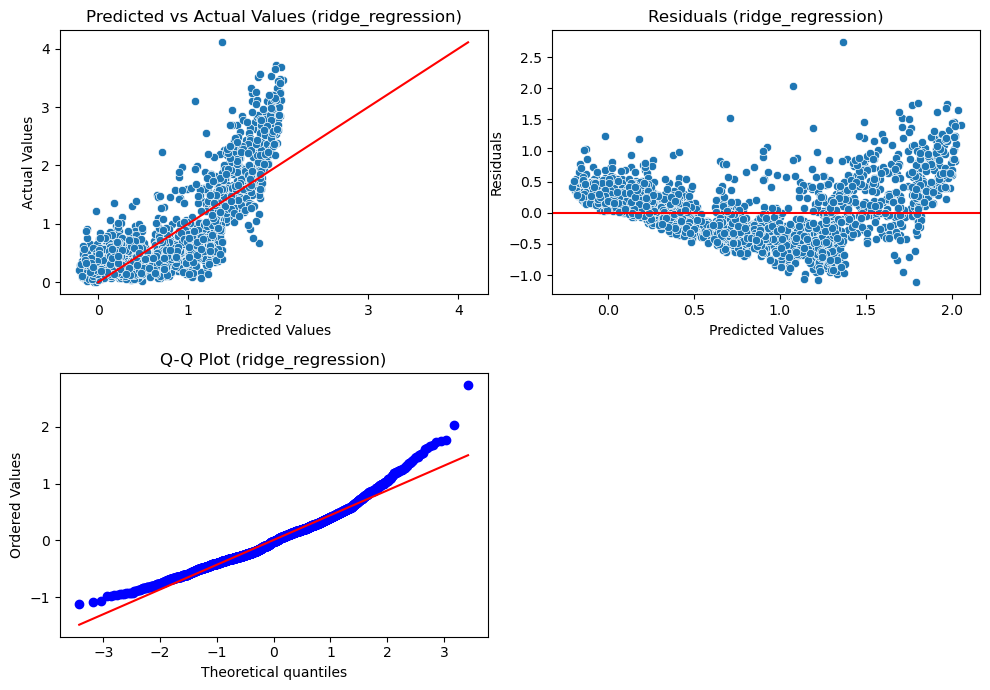

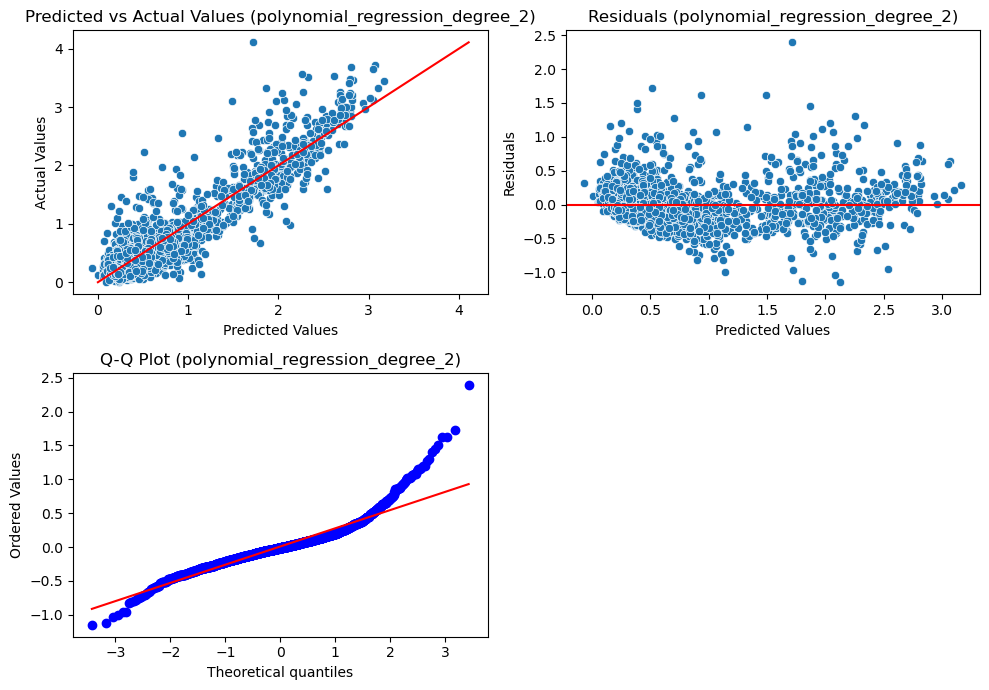

In [33]:
# Loop over the models
for model_name, model in models.items():
    # Fit the model and generate predictions
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Calculate residuals
    residuals = y_test - y_pred

    # Create a figure for the plots
    plt.figure(figsize=(10, 7))

    # Plot predicted vs actual values
    plt.subplot(221)
    sns.scatterplot(x=y_pred, y=y_test)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')  # Add red line (y=x)
    plt.xlabel('Predicted Values')
    plt.ylabel('Actual Values')
    plt.title(f'Predicted vs Actual Values ({model_name})')

    # Plot residuals
    plt.subplot(222)
    sns.scatterplot(x=y_pred, y=residuals)
    plt.axhline(y=0, color='red')  # Add red line at y=0
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title(f'Residuals ({model_name})')

    # Plot a Q-Q plot of the residuals
    plt.subplot(223)
    stats.probplot(residuals, dist="norm", plot=plt)
    plt.title(f'Q-Q Plot ({model_name})')

    plt.tight_layout()
    plt.show()

In [34]:
# Fit the best model to the training data
best_model = make_pipeline(PolynomialFeatures(2), LinearRegression())
best_model.fit(X_train, y_train)

# Predict on the test data
y_pred = best_model.predict(X_test)

# Calculate the Mean Squared Error on the test data
mse_test = mean_squared_error(y_test, y_pred)

print(f'Test MSE: {mse_test}')

Test MSE: 0.07947277265964221


In [35]:
# Fit the best model to the training data
best_model = make_pipeline(PolynomialFeatures(2), LinearRegression())
best_model.fit(X_train, y_train)

# Predict on the test data
y_pred = best_model.predict(X_test)

# Calculate the Mean Squared Error on the test data
mse_test = mean_squared_error(y_test, y_pred)

print(f'Test MSE: {mse_test}')


Test MSE: 0.07947277265964221


# 4. Genre

We have written this article in the Magazine Genre while following the Martini Glass Structure. By this, we mean that we have started out with a broader scope, which was a comparison of Greater Copenhagen to the rest of Denmark. Then we have found some interesting insights and afterwards narrowed our scope down to understand these insights better within the Region of Copenhagen. 

### 4.1 Visual Narrative:
We have applied a variety of different visual narrative tactics to assist and facilitate our story telling. From a visual structuring perspective, we have used Progress Bars in our bar plots in section 5.1 below. We have done so in order visualize a development over time with side by side bars to compare different categories. This is a way to include a lot of information into one visualization that is easy to follow for the reader and does not feel confusing or overcrowded with information. From a highlighting perspetive, we have used a combination of Motion and Feature Distinction in our Maps in section 5.2 below. We have used an intense color scheme as feature distinction so that the reader quickly cathces the areas with large differenes, which is what we are trying to highlight in this story on inequality. And at the same time we are using Motion in form of a Gif, where the reader can press play and the map changes from year to year. In order to transition from one visualization to the next, we have applied Continuity Editing with descriptive texts that guides the reader.

### 4.2 Narrative Structure:
With a focus on narrative structure within each visualization, we have had a strong focus on interactivity to engage the reader with the story. But first of all from an ordering perspective, we have guided the reader through our visualizations linearly by focusing on the development over time. As mentioned, we have wanted to engage the reader with interactive plots, where we have applied drop-down menus for filtering as well as informative tool-tips for hover highlighting. Due to limitations in our plots, we have also used explicit instructions in order to guide the reader on how to interact with the visualizations. Although the reader can play around with the visualizations and find interesting insights, we have used an accompanying article to highlight the most important messages that we have found.

# 5. Visualizations

As mentioned above, we have had a strong focus on interactivity in our visualizations. For that reason, we have applied the open source graphing library of Plotly, which is a leading Python library for interactive, scientific data visualization.

## 5.1 Plotting timelines - Greater Copenhagen vs Denmark

Starting at the wide foot of our martini glass structure, we have made comparative visualizations between the Region of Greater Copenhagen and Denmark as a whole. We have decided to create a side by side bar plot with our 3 continous variables respectively on the y-axis and years on the x-axis. The side by side bars show Denmark and Greater Copenhagen.

### Data prep
As a first step, a bit of data preparation was required to set up the right data frames for the visualization., such as filtering for the correct regions, creating lists with unique variables and grouping over these variables. We have used the sum of the weighted variables in the grouping by, to take into considerations the number of observations and their respective weight.

### Plotly side by side bar
We have used the graph.objs library of Plotly to create the side by side bar plots, where we have added a trace for DK and CPH respectively to show them as bars side by side. We have used different colors for CPH and DK together with a descriptive legend to visually separate them.

### Drop down menus
Four drop down menus are created for each of the demographic variables. These are then placed side by side on the top of the visualization. We had expected it to be possible to create cross-filtering, so that several drop down filters could be applied at the same time, slicing and dicing the data set inside the visualization. In the process, after trying many different approaches and reading blogs and Stack Overflow, we found out that this was not possible with more than 2 attributes. For that reason only one drop down filter can be applied at the time.

In [36]:
# Data preparation for visualization:

# Data frame with Greater Copenhagen and Denmark
df_cop_dk = df_2[(df_2.municipality == 'Denmark') | (df_2.municipality == 'Greater Copenhagen')]

# unique years and municipalities for plotting
years = df_cop_dk.year.unique()
municipalities = df_cop_dk.municipality.unique()

# Yearly average income
dk_yearly_avg_inc = df_cop_dk[(df_cop_dk.municipality=='Denmark')].groupby(['year', 'municipality'])['weighted_inc_mun'].sum()
cop_yearly_avg_inc = df_cop_dk[(df_cop_dk.municipality=='Greater Copenhagen')].groupby(['year', 'municipality'])['weighted_inc_mun'].sum()
df_income = df_cop_dk.groupby(['year', 'municipality'])['weighted_inc_mun'].sum().reset_index(name='count')

# Yearly average days in hospital
dk_yearly_avg_hosp_days = df_cop_dk[(df_cop_dk.municipality=='Denmark')].groupby(['year', 'municipality'])['weighted_hosp_days_mun'].sum()
cop_yearly_avg_hosp_days = df_cop_dk[(df_cop_dk.municipality=='Greater Copenhagen')].groupby(['year', 'municipality'])['weighted_hosp_days_mun'].sum()
df_days = df_cop_dk.groupby(['year', 'municipality'])['weighted_hosp_days_mun'].sum().reset_index(name='count')

# Yearly average hospitalizations
dk_yearly_avg_hosp_times = df_cop_dk[(df_cop_dk.municipality=='Denmark')].groupby(['year', 'municipality'])['weighted_hospitalizations_mun'].sum()
cop_yearly_avg_hosp_times = df_cop_dk[(df_cop_dk.municipality=='Greater Copenhagen')].groupby(['year', 'municipality'])['weighted_hospitalizations_mun'].sum()
df_hosp = df_cop_dk.groupby(['year', 'municipality'])['weighted_hospitalizations_mun'].sum().reset_index(name='count')

### Interactive visualization for income with filters for age, gender, education and ethnicity

In [37]:
# Create the initial plot
fig = go.Figure()
# Line plot (commented out)
#fig = px.line(df_income, x='year', y='count', color='municipality', markers=True, width=900, height=400)
#fig.update_traces(line_color='rgb(55, 83, 109)', selector=dict(name='Denmark'))
#fig.update_traces(line_color='rgb(26, 118, 255)', selector=dict(name='Greater Copenhagen'))
# Bar plot 
fig.add_trace(go.Bar(x=years,
                y=dk_yearly_avg_inc,
                name='Denmark',
                marker_color='rgb(55, 83, 109)'
                ))
fig.add_trace(go.Bar(x=years,
                y=cop_yearly_avg_inc,
                name='Greater Copenhagen',
                marker_color='rgb(26, 118, 255)'
                ))

# Define the dropdown menu
genders = df_cop_dk.gender.unique()
buttons = []
# Add button for all genders
buttons.append(dict(method='update',
                    label='Gender',
                    args=[{'x': [years]*2,
                           'y': [dk_yearly_avg_inc, cop_yearly_avg_inc],
                           'visible': [True]*2}],
                    )
             )


# Add button for each gender
for gender in genders:
    dk_yearly_avg_count = df_cop_dk[(df_cop_dk.municipality=='Denmark') & (df_cop_dk.gender==gender)].groupby(['year', 'municipality', 'gender'])['weighted_inc_gen_mun'].sum()
    cop_yearly_avg_count = df_cop_dk[(df_cop_dk.municipality=='Greater Copenhagen') & (df_cop_dk.gender==gender)].groupby(['year', 'municipality', 'gender'])['weighted_inc_gen_mun'].sum()
    buttons.append(dict(method='update',
                        label=gender,
                        args=[{'x': [years]*2,
                               'y': [dk_yearly_avg_count, cop_yearly_avg_count],
                               'visible': [True]*2}],
                        )   
                 )

# Define the dropdown menu for Age
ages = df_cop_dk.age.unique()
buttons_2 = []
# Add button for all ages
buttons_2.append(dict(method='update',
                    label='Age',
                    args=[{'x': [years]*4,
                           'y': [dk_yearly_avg_inc, cop_yearly_avg_inc],
                           'visible': [True]*4}],
                    )
             )
# Add button for each age
for age in ages:
    age_dk_yearly_avg_count = df_cop_dk[(df_cop_dk.municipality=='Denmark') & (df_cop_dk.age==age)].groupby(['year', 'municipality', 'age'])['weighted_inc_age_mun'].sum()
    age_cop_yearly_avg_count = df_cop_dk[(df_cop_dk.municipality=='Greater Copenhagen') & (df_cop_dk.age==age)].groupby(['year', 'municipality', 'age'])['weighted_inc_age_mun'].sum()
    buttons_2.append(dict(method='update',
                        label=age,
                        args=[{'x': [years]*4,
                               'y': [age_dk_yearly_avg_count, age_cop_yearly_avg_count],
                               'visible': [True]*4}],
                        )
                 )
    
# Define the dropdown menu for ethnicity
ethnicities = df_cop_dk.ethnicity.unique()
buttons_3 = []
# Add button for all ethnicities
buttons_3.append(dict(method='update',
                    label='Ethnicity',
                    args=[{'x': [years]*3,
                           'y': [dk_yearly_avg_inc, cop_yearly_avg_inc],
                           'visible': [True]*3}],
                    )
             )
# Add button for each ehtnicity
for ethnicity in ethnicities:
    eth_dk_yearly_avg_count = df_cop_dk[(df_cop_dk.municipality=='Denmark') & (df_cop_dk.ethnicity==ethnicity)].groupby(['year', 'municipality', 'ethnicity'])['weighted_inc_eth_mun'].sum()
    eth_cop_yearly_avg_count = df_cop_dk[(df_cop_dk.municipality=='Greater Copenhagen') & (df_cop_dk.ethnicity==ethnicity)].groupby(['year', 'municipality', 'ethnicity'])['weighted_inc_eth_mun'].sum()
    buttons_3.append(dict(method='update',
                        label=ethnicity,
                        args=[{'x': [years]*3,
                               'y': [eth_dk_yearly_avg_count, eth_cop_yearly_avg_count],
                               'visible': [True]*3}],
    )
                       )
    
# Define the dropdown menu for education
educations = df_cop_dk.education.unique()
buttons_4 = []
# Add button for all educations
buttons_4.append(dict(method='update',
                    label='Education',
                    args=[{'x': [years]*2,
                           'y': [dk_yearly_avg_inc, cop_yearly_avg_inc],
                           'visible': [True]*2}],
                    )
             )
# Add button for each education
for education in educations:
    edu_dk_yearly_avg_count = df_cop_dk[(df_cop_dk.municipality=='Denmark') & (df_cop_dk.education==education)].groupby(['year', 'municipality', 'education'])['weighted_inc_edu_mun'].sum()
    edu_cop_yearly_avg_count = df_cop_dk[(df_cop_dk.municipality=='Greater Copenhagen') & (df_cop_dk.education==education)].groupby(['year', 'municipality', 'education'])['weighted_inc_edu_mun'].sum()
    buttons_4.append(dict(method='update',
                        label=education,
                        args=[{'x': [years]*2,
                               'y': [edu_dk_yearly_avg_count, edu_cop_yearly_avg_count],
                               'visible': [True]*2}],
    )
                       )

updatemenus = [{'buttons': buttons,
                'direction': 'down',
                'showactive': True,
                'active': 0,
                'y': 1.13,
                'x': 0.15}, 
                {'buttons': buttons_2,
                 'direction': 'down',
                 'showactive': True,
                 'active': 0,
                 'y': 1.13,
                 'x': 0.27}, 
                 {'buttons': buttons_3,
                 'direction': 'down',
                 'showactive': True,
                 'active': 0,
                 'y': 1.13,
                 'x': 0.68},
                 {'buttons': buttons_4,
                 'direction': 'down',
                 'showactive': True,
                 'active': 0,
                 'y': 1.13,
                 'x': 0.92}]


# Update the layout to add the dropdown menu and set the title
fig.update_layout(
    updatemenus=updatemenus,
    title='<b>Annual dissposable income by gender, age, education or ethnicity<b>',
    xaxis_tickfont_size=14,
    xaxis=dict(
              title='',
              titlefont_size=16,
              domain=[0, 1],
    ),
    # fix the yaxis range to be the same for all plots
    yaxis=dict(
        title='<b>Income<b>',
        titlefont_size=16,
        tickfont_size=14,
        range=[0, 390000],
    ),
    legend=dict(
        title='',
        x=0.01,
        y=1,
        bgcolor='rgba(255, 255, 255, 0)',
        bordercolor='rgba(255, 255, 255, 0)'
    ),
    barmode='group',
    bargap=0.15, # gap between bars of adjacent location coordinates.
    bargroupgap=0.1 # gap between bars of the same location coordinate.
)
fig.write_html('dk_cph_income_bar.html')
fig.show()

### Interactive visualization for days in hospital with filters for age, gender, education and ethnicity

In [38]:
# Create the initial plot
fig = go.Figure()
# Line plot (commented out)
#fig = px.line(df_income, x='year', y='count', color='municipality', markers=True, width=900, height=400)
#fig.update_traces(line_color='rgb(55, 83, 109)', selector=dict(name='Denmark'))
#fig.update_traces(line_color='rgb(26, 118, 255)', selector=dict(name='Greater Copenhagen'))
# Bar plot 
fig.add_trace(go.Bar(x=years,
                y=dk_yearly_avg_hosp_days,
                name='Denmark',
                marker_color='rgb(55, 83, 109)'
                ))
fig.add_trace(go.Bar(x=years,
                y=cop_yearly_avg_hosp_days,
                name='Greater Copenhagen',
                marker_color='rgb(26, 118, 255)'
                ))

# Define the dropdown menu
genders = df_cop_dk.gender.unique()
buttons = []
# Add button for all genders
buttons.append(dict(method='update',
                    label='Gender',
                    args=[{'x': [years]*2,
                           'y': [dk_yearly_avg_hosp_days, cop_yearly_avg_hosp_days],
                           'visible': [True]*2}],
                    )
             )


# Add button for each gender
for gender in genders:
    dk_yearly_avg_count = df_cop_dk[(df_cop_dk.municipality=='Denmark') & (df_cop_dk.gender==gender)].groupby(['year', 'municipality', 'gender'])['weighted_days_gen_mun'].sum()
    cop_yearly_avg_count = df_cop_dk[(df_cop_dk.municipality=='Greater Copenhagen') & (df_cop_dk.gender==gender)].groupby(['year', 'municipality', 'gender'])['weighted_days_gen_mun'].sum()
    buttons.append(dict(method='update',
                        label=gender,
                        args=[{'x': [years]*2,
                               'y': [dk_yearly_avg_count, cop_yearly_avg_count],
                               'visible': [True]*2}],
                        )
                        # add selection to the list of visible values
                        
                 )

# Define the dropdown menu for Age
ages = df_cop_dk.age.unique()
buttons_2 = []
# Add button for all ages
buttons_2.append(dict(method='update',
                    label='Age',
                    args=[{'x': [years]*4,
                           'y': [dk_yearly_avg_hosp_days, cop_yearly_avg_hosp_days],
                           'visible': [True]*4}],
                    )
             )
# Add button for each age
for age in ages:
    age_dk_yearly_avg_count = df_cop_dk[(df_cop_dk.municipality=='Denmark') & (df_cop_dk.age==age)].groupby(['year', 'municipality', 'age'])['weighted_days_age_mun'].sum()
    age_cop_yearly_avg_count = df_cop_dk[(df_cop_dk.municipality=='Greater Copenhagen') & (df_cop_dk.age==age)].groupby(['year', 'municipality', 'age'])['weighted_days_age_mun'].sum()
    buttons_2.append(dict(method='update',
                        label=age,
                        args=[{'x': [years]*4,
                               'y': [age_dk_yearly_avg_count, age_cop_yearly_avg_count],
                               'visible': [True]*4}],
                        )
                 )
    
# Define the dropdown menu for ethnicity
ethnicities = df_cop_dk.ethnicity.unique()
buttons_3 = []
# Add button for all ethnicities
buttons_3.append(dict(method='update',
                    label='Ethnicity',
                    args=[{'x': [years]*3,
                           'y': [dk_yearly_avg_hosp_days, cop_yearly_avg_hosp_days],
                           'visible': [True]*3}],
                    )
             )
# Add button for each ehtnicity
for ethnicity in ethnicities:
    eth_dk_yearly_avg_count = df_cop_dk[(df_cop_dk.municipality=='Denmark') & (df_cop_dk.ethnicity==ethnicity)].groupby(['year', 'municipality', 'ethnicity'])['weighted_days_eth_mun'].sum()
    eth_cop_yearly_avg_count = df_cop_dk[(df_cop_dk.municipality=='Greater Copenhagen') & (df_cop_dk.ethnicity==ethnicity)].groupby(['year', 'municipality', 'ethnicity'])['weighted_days_eth_mun'].sum()
    buttons_3.append(dict(method='update',
                        label=ethnicity,
                        args=[{'x': [years]*3,
                               'y': [eth_dk_yearly_avg_count, eth_cop_yearly_avg_count],
                               'visible': [True]*3}],
    )
                       )
    
# Define the dropdown menu for education
educations = df_cop_dk.education.unique()
buttons_4 = []
# Add button for all educations
buttons_4.append(dict(method='update',
                    label='Education',
                    args=[{'x': [years]*2,
                           'y': [dk_yearly_avg_hosp_days, cop_yearly_avg_hosp_days],
                           'visible': [True]*2}],
                    )
             )
# Add button for each education
for education in educations:
    edu_dk_yearly_avg_count = df_cop_dk[(df_cop_dk.municipality=='Denmark') & (df_cop_dk.education==education)].groupby(['year', 'municipality', 'education'])['weighted_days_edu_mun'].sum()
    edu_cop_yearly_avg_count = df_cop_dk[(df_cop_dk.municipality=='Greater Copenhagen') & (df_cop_dk.education==education)].groupby(['year', 'municipality', 'education'])['weighted_days_edu_mun'].sum()
    buttons_4.append(dict(method='update',
                        label=education,
                        args=[{'x': [years]*2,
                               'y': [edu_dk_yearly_avg_count, edu_cop_yearly_avg_count],
                               'visible': [True]*2}],
    )
                       )

updatemenus = [{'buttons': buttons,
                'direction': 'down',
                'showactive': True,
                'active': 0,
                'y': 1.13,
                'x': 0.15}, 
                {'buttons': buttons_2,
                 'direction': 'down',
                 'showactive': True,
                 'active': 0,
                 'y': 1.13,
                 'x': 0.27}, 
                 {'buttons': buttons_3,
                 'direction': 'down',
                 'showactive': True,
                 'active': 0,
                 'y': 1.13,
                 'x': 0.68},
                 {'buttons': buttons_4,
                 'direction': 'down',
                 'showactive': True,
                 'active': 0,
                 'y': 1.13,
                 'x': 0.92}]


# Update the layout to add the dropdown menu and set the title
fig.update_layout(
    updatemenus=updatemenus,
    title='<b>Annual number of days spent in the hospital by gender, age, education or ethnicity<b>',
    xaxis_tickfont_size=14,
    xaxis=dict(
              title='',
              titlefont_size=16,
              domain=[0, 1],
    ),
    # fix the yaxis range to be the same for all plots
    yaxis=dict(
        title='<b>Days spent in hospital<b>',
        titlefont_size=16,
        tickfont_size=14,
        range=[0, 3],
    ),
    legend=dict(
        title='',
        x=0.01,
        y=1,
        bgcolor='rgba(255, 255, 255, 0)',
        bordercolor='rgba(255, 255, 255, 0)'
    ),
    barmode='group',
    bargap=0.15, # gap between bars of adjacent location coordinates.
    bargroupgap=0.1 # gap between bars of the same location coordinate.
)
fig.write_html('dk_cph_days_hospital_bar.html')
fig.show()

### Interactive visualization for number of hospitalizations with filters for age, gender, education and ethnicity

In [39]:
# Create the initial plot
fig = go.Figure()
# Line plot (commented out)
#fig = px.line(df_income, x='year', y='count', color='municipality', markers=True, width=900, height=400)
#fig.update_traces(line_color='rgb(55, 83, 109)', selector=dict(name='Denmark'))
#fig.update_traces(line_color='rgb(26, 118, 255)', selector=dict(name='Greater Copenhagen'))
# Bar plot 
fig.add_trace(go.Bar(x=years,
                y=dk_yearly_avg_hosp_times,
                name='Denmark',
                marker_color='rgb(55, 83, 109)'
                ))
fig.add_trace(go.Bar(x=years,
                y=cop_yearly_avg_hosp_times,
                name='Greater Copenhagen',
                marker_color='rgb(26, 118, 255)'
                ))

# Define the dropdown menu
genders = df_cop_dk.gender.unique()
buttons = []
# Add button for all genders
buttons.append(dict(method='update',
                    label='Gender',
                    args=[{'x': [years]*2,
                           'y': [dk_yearly_avg_hosp_times, cop_yearly_avg_hosp_times],
                           'visible': [True]*2}],
                    )
             )


# Add button for each gender
for gender in genders:
    dk_yearly_avg_count = df_cop_dk[(df_cop_dk.municipality=='Denmark') & (df_cop_dk.gender==gender)].groupby(['year', 'municipality', 'gender'])['weighted_hosp_gen_mun'].sum()
    cop_yearly_avg_count = df_cop_dk[(df_cop_dk.municipality=='Greater Copenhagen') & (df_cop_dk.gender==gender)].groupby(['year', 'municipality', 'gender'])['weighted_hosp_gen_mun'].sum()
    buttons.append(dict(method='update',
                        label=gender,
                        args=[{'x': [years]*2,
                               'y': [dk_yearly_avg_count, cop_yearly_avg_count],
                               'visible': [True]*2}],
                        )
                        # add selection to the list of visible values
                        
                 )

# Define the dropdown menu for Age
ages = df_cop_dk.age.unique()
buttons_2 = []
# Add button for all ages
buttons_2.append(dict(method='update',
                    label='Age',
                    args=[{'x': [years]*4,
                           'y': [dk_yearly_avg_hosp_times, cop_yearly_avg_hosp_times],
                           'visible': [True]*4}],
                    )
             )
# Add button for each age
for age in ages:
    age_dk_yearly_avg_count = df_cop_dk[(df_cop_dk.municipality=='Denmark') & (df_cop_dk.age==age)].groupby(['year', 'municipality', 'age'])['weighted_hosp_age_mun'].sum()
    age_cop_yearly_avg_count = df_cop_dk[(df_cop_dk.municipality=='Greater Copenhagen') & (df_cop_dk.age==age)].groupby(['year', 'municipality', 'age'])['weighted_hosp_age_mun'].sum()
    buttons_2.append(dict(method='update',
                        label=age,
                        args=[{'x': [years]*4,
                               'y': [age_dk_yearly_avg_count, age_cop_yearly_avg_count],
                               'visible': [True]*4}],
                        )
                 )
    
# Define the dropdown menu for ethnicity
ethnicities = df_cop_dk.ethnicity.unique()
buttons_3 = []
# Add button for all ethnicities
buttons_3.append(dict(method='update',
                    label='Ethnicity',
                    args=[{'x': [years]*3,
                           'y': [dk_yearly_avg_hosp_times, cop_yearly_avg_hosp_times],
                           'visible': [True]*3}],
                    )
             )
# Add button for each ehtnicity
for ethnicity in ethnicities:
    eth_dk_yearly_avg_count = df_cop_dk[(df_cop_dk.municipality=='Denmark') & (df_cop_dk.ethnicity==ethnicity)].groupby(['year', 'municipality', 'ethnicity'])['weighted_hosp_eth_mun'].sum()
    eth_cop_yearly_avg_count = df_cop_dk[(df_cop_dk.municipality=='Greater Copenhagen') & (df_cop_dk.ethnicity==ethnicity)].groupby(['year', 'municipality', 'ethnicity'])['weighted_hosp_eth_mun'].sum()
    buttons_3.append(dict(method='update',
                        label=ethnicity,
                        args=[{'x': [years]*3,
                               'y': [eth_dk_yearly_avg_count, eth_cop_yearly_avg_count],
                               'visible': [True]*3}],
    )
                       )
    
# Define the dropdown menu for education
educations = df_cop_dk.education.unique()
buttons_4 = []
# Add button for all educations
buttons_4.append(dict(method='update',
                    label='Education',
                    args=[{'x': [years]*2,
                           'y': [dk_yearly_avg_hosp_times, cop_yearly_avg_hosp_times],
                           'visible': [True]*2}],
                    )
             )
# Add button for each education
for education in educations:
    edu_dk_yearly_avg_count = df_cop_dk[(df_cop_dk.municipality=='Denmark') & (df_cop_dk.education==education)].groupby(['year', 'municipality', 'education'])['weighted_hosp_edu_mun'].sum()
    edu_cop_yearly_avg_count = df_cop_dk[(df_cop_dk.municipality=='Greater Copenhagen') & (df_cop_dk.education==education)].groupby(['year', 'municipality', 'education'])['weighted_hosp_edu_mun'].sum()
    buttons_4.append(dict(method='update',
                        label=education,
                        args=[{'x': [years]*2,
                               'y': [edu_dk_yearly_avg_count, edu_cop_yearly_avg_count],
                               'visible': [True]*2}],
    )
                       )

updatemenus = [{'buttons': buttons,
                'direction': 'down',
                'showactive': True,
                'active': 0,
                'y': 1.13,
                'x': 0.15}, 
                {'buttons': buttons_2,
                 'direction': 'down',
                 'showactive': True,
                 'active': 0,
                 'y': 1.13,
                 'x': 0.27}, 
                 {'buttons': buttons_3,
                 'direction': 'down',
                 'showactive': True,
                 'active': 0,
                 'y': 1.13,
                 'x': 0.68},
                 {'buttons': buttons_4,
                 'direction': 'down',
                 'showactive': True,
                 'active': 0,
                 'y': 1.13,
                 'x': 0.92}]


# Update the layout to add the dropdown menu and set the title
fig.update_layout(
    updatemenus=updatemenus,
    title='<b>Annual number of hospitalizations by gender, age, education or ethnicity<b>',
    xaxis_tickfont_size=14,
    xaxis=dict(
              title='',
              titlefont_size=16,
              domain=[0, 1],
    ),
    # fix the yaxis range to be the same for all plots
    yaxis=dict(
        title='<b>Number of hospitalizations<b>',
        titlefont_size=16,
        tickfont_size=14,
        range=[0, 0.5],
    ),
    legend=dict(
        title='',
        x=0.01,
        y=1,
        bgcolor='rgba(255, 255, 255, 0)',
        bordercolor='rgba(255, 255, 255, 0)'
    ),
    barmode='group',
    bargap=0.15, # gap between bars of adjacent location coordinates.
    bargroupgap=0.1 # gap between bars of the same location coordinate.
)
fig.write_html('dk_cph_hospitalizations_bar.html')
fig.show()

### Timelines for Income, Days in Hospital and # of Hospitalizations
In the process we also created a more simple line plot over time for each of the three continous variables. At the end of the day we decided not to use these in the article, as the visualizations above capture the same story told in these visualizations.

In [40]:
# Group the data by 'year' and 'municipality', then calculate the sum of 'weighted_inc_mun' for each group
df_income = df_cop_dk.groupby(['year', 'municipality'])['weighted_inc_mun'].sum().reset_index(name='count')

# Create a line chart using Plotly Express, with 'year' on the x-axis, 'count' on the y-axis, and colored by 'municipality'
fig = px.line(df_income, x='year', y='count', color='municipality', markers=True, width=900, height=300)  # Adding markers to the line plot for better visibility of data points

# update line colors to rgb(55, 83, 109) for Denmark and rgb(26, 118, 255) for Greater Copenhagen
fig.update_traces(line_color='rgb(55, 83, 109)', selector=dict(name='Denmark'))
fig.update_traces(line_color='rgb(26, 118, 255)', selector=dict(name='Greater Copenhagen'))

# Edit the layout
fig.update_layout(title='<b>Income by year per municipality<b>',
                   xaxis_title='',
                   yaxis_title='<b>Income DKK<b>')

fig.show()

In [41]:
# Group the data by 'year' and 'municipality', then calculate the sum of 'weighted_hosp_days_mun' for each group
df_hosp_days = df_cop_dk.groupby(['year', 'municipality'])['weighted_hosp_days_mun'].sum().reset_index(name='count')

# Create a line chart using Plotly Express, with 'year' on the x-axis, 'count' on the y-axis, and colored by 'municipality'
fig = px.line(df_hosp_days, x='year', y='count', color='municipality', markers=True, width=900, height=300)  # Adding markers to the line plot for better visibility of data points

# update line colors to rgb(55, 83, 109) for Denmark and rgb(26, 118, 255) for Greater Copenhagen
fig.update_traces(line_color='rgb(55, 83, 109)', selector=dict(name='Denmark'))
fig.update_traces(line_color='rgb(26, 118, 255)', selector=dict(name='Greater Copenhagen'))

# Edit the layout
fig.update_layout(title='<b>Days spent in hospital<b>',
                   xaxis_title='',
                   yaxis_title='<b>Days per hospital visit<b>')

fig.show()

In [42]:
# Group the data by 'year' and 'municipality', then calculate the sum of 'weighted_hospitalizations_mun' for each group
df_hosp_times = df_cop_dk.groupby(['year', 'municipality'])['weighted_hospitalizations_mun'].sum().reset_index(name='count')

# Create a line chart using Plotly Express, with 'year' on the x-axis, 'count' on the y-axis, and colored by 'municipality'
fig = px.line(df_hosp_times, x='year', y='count', color='municipality', markers=True, width=900, height=300)  # Adding markers to the line plot for better visibility of data points

# update line colors to rgb(55, 83, 109) for Denmark and rgb(26, 118, 255) for Greater Copenhagen
fig.update_traces(line_color='rgb(55, 83, 109)', selector=dict(name='Denmark'))
fig.update_traces(line_color='rgb(26, 118, 255)', selector=dict(name='Greater Copenhagen'))

# Edit the layout
fig.update_layout(title='<b> Number of hospitalizations per year <b>',
                   xaxis_title='<b>Year<b>',
                   yaxis_title='<b>Number of hospitalizations<b>')

fig.show()

## 5.2 Plotting maps - Copenhagen municipalities

We're also displaying the above processed data on a map of the Greater Copenhagen area, for which we use Plotly's Choropleth Mapbox. In order to achieve this, we needed GeoJSON data, which we obtained from [Information Lab](https://lab.information.dk/). 

But this GeoJSON ended up needing a lot of processing to be displayable properly.

### Processing the GeoJSON

As Denmark consists of a lot of islands and some municipalities occupy more than one geometry, the GeoJSON initially contained multiple polygons for the same municipality, which Plotly is not equipped to handle. It will not display any warnings, but it's only going to display the first instance of the municipality that it finds, which resulted in unexpected behavior on the Copenhagen map. Therefore we had to find a way to remove these redundancies.

After some research, we found [MapShaper](https://mapshaper.org/), which is a handy tool for manipulating and exporting map data. Here we could import our GeoJSON, which got displayed on a map inside the tool. There we had the option to select municipalities, merge them and edit their attributes. It was a very manual and tedious job (merging all of 153 small islands into Tårnby is not a small feat), but eventually we ended up with the desired file. 

After that we were almost done, but there were issues arising from the file encoding as well, we had to convert it to ISO8859-1 to handle the special characters. 

After all this, there was only one issue remaining: rendering a time-series map with the processed GeoJSON took too long. We don't actually know how long, as we stopped it after around 40 minutes. So we went back to MapShaper, and simplified the GeoJSON file, to contain less and simpler polygons, and it finally worked as expected. The result of this can be seen below.

### Maps
Below we see three maps, each depicting a different aspect of Copenhagen data. 

This first map depicts the average income per municipality in the Greater Copenhagen area, from 2005 to 2018.

In [43]:
df_mun = df_2.loc[(df_2['municipality'] != 'Denmark') & (df_2['municipality'] != 'Greater Copenhagen')]
df_mun_income = df_mun.groupby(['year', 'municipality'])['weighted_inc_mun'].sum().reset_index(name='count')
df_mun_hosp_days = df_mun.groupby(['year', 'municipality'])['weighted_hosp_days_mun'].sum().reset_index(name='count')
df_mun_hosp_times = df_mun.groupby(['year', 'municipality'])['weighted_hospitalizations_mun'].sum().reset_index(name='count')

In [44]:
import json
with open('denmark.json', encoding='iso-8859-1') as f:
    counties = json.load(f)

fig = px.choropleth_mapbox(df_mun_income, geojson=counties, locations='municipality', featureidkey='properties.KOMNAVN', color='count',
                            color_continuous_scale="hot_r",
                            range_color=(200000, 520000),
                            mapbox_style="carto-positron",
                            zoom=9, center = {"lat": 55.7061, "lon": 12.5683},
                            animation_frame='year',
                            opacity=0.5,
                            width=900,
                            height=650,
                            labels={'year': 'Year', 'count': ''},
                            title='<b>Average income per municipality per year (DKK)</b>'
)
fig.update_layout(margin={"r":0,"l":0, "b":0}, title_x=0.5)
fig.layout.sliders[0].pad.t = 10
fig.layout.updatemenus[0].pad.t = 10
fig.layout.updatemenus[0].buttons[0].args[1]["frame"]["duration"] = 900
fig.layout.updatemenus[0].buttons[0].args[1]["transition"]["duration"] = 900
fig.write_html('cph_income_time_map.html')
#fig.show()

This map depicts the average days spent in hospital during the years.

In [45]:
fig = px.choropleth_mapbox(df_mun_hosp_days, geojson=counties, locations='municipality', featureidkey='properties.KOMNAVN', color='count',
                            color_continuous_scale="hot_r",
                            range_color=(0.6, 1.3),
                            mapbox_style="carto-positron",
                            zoom=9, center = {"lat": 55.7061, "lon": 12.5683},
                            animation_frame='year',
                            opacity=0.5,
                            width=900,
                            height=650,
                            labels={'year': 'Year', 'count': ''},
                            title='<b>Weighted average of days spent in hospital per municipality per year</b>'
)
fig.update_layout(margin={"r":0,"l":0, "b":0}, title_x=0.5)
fig.layout.sliders[0].pad.t = 10
fig.layout.updatemenus[0].pad.t = 10
fig.layout.updatemenus[0].buttons[0].args[1]["frame"]["duration"] = 900
fig.layout.updatemenus[0].buttons[0].args[1]["transition"]["duration"] = 900
fig.write_html('cph_hosp_days_time_map.html')
#fig.show()

And the last one shows the number of hospital visits by municipality and year. 

In [46]:
fig = px.choropleth_mapbox(df_mun_hosp_times, geojson=counties, locations='municipality', featureidkey='properties.KOMNAVN', color='count',
                            color_continuous_scale="hot_r",
                            range_color=(0.14, 0.24),
                            mapbox_style="carto-positron",
                            zoom=9, center = {"lat": 55.7061, "lon": 12.5683},
                            animation_frame='year',
                            opacity=0.5,
                            width=900,
                            height=650,
                            labels={'year': 'Year', 'count': ''},
                            title='<b>Weighted average of times of hospitalizations per municipality per year</b>'
)
fig.update_layout(margin={"r":0,"l":0, "b":0}, title_x=0.5)
fig.layout.sliders[0].pad.t = 10
fig.layout.updatemenus[0].pad.t = 10
fig.layout.updatemenus[0].buttons[0].args[1]["frame"]["duration"] = 900
fig.layout.updatemenus[0].buttons[0].args[1]["transition"]["duration"] = 900
fig.write_html('cph_hosp_times_time_map.html')
#fig.show()

From running the time series it is visible, that with the salaries raising the average time spent in hospitals is decreasing. But what's even more interesting is that the number of hospital visits seems to increase everywhere expcept for Copenhagen municipality. 

# 6. Discussion
In general, this has been a fun and informative data set to work on. However, it has also had a few drawbacks.

### Velstand & Ulighed - tool by Rockwool Fonden
When we first found the Vesltand & Ulighed tool by Rockwool Fonden, and saw that the underlying data could be downloaded, we got very excited to work with it. And it wasn't until we had advanced quite a lot with our idea generations for the project, that we realized that only small chunks of data could be downloaded at the time, and that these required a lot of cleaning to get ready for a final data set. At this point, it felt too late to go looking for a different data set. As the data preparation took a very long time, we had to limit ourselves to only work with 3 continous variables, Disposable Income, Days in Hospital and Number of Hospitalizations. Many more interesting attributes were available, such as different measures for education as well as Gini Coefficients for measuring inequality. 

### Aggregated data
Another drawback of the data from Velstand & Ulighed, is the fact that it is aggregated data where each row of data represents a group of people and their income and health values are an average of that specific group. This put a limit to the number of rows we had to work with. For our data visualization, the aggregated data was not a problem, we just had to take into the consideration the weighted numbers based on # of Observations. However, for our machine learning models, having row-level data available would have given much more informative data sets with many rows to train our models on.

### Cross filtering
As already mentioned, we wished to apply cross filtering for our comparison between Denmark and Greater Copenhagen, which we after a while found out was not possible following the method that we had. There was one way to do so, which was through Plotly's Dash features which is a platform for building, scaling, and deploying data apps in Python. Although Plotly mention that Dash is suppose to be a low-code feature, we were not able to set up the proper apps and get them integrated with html to our Jekyll webpage.

# 7. Contributions
In cooperation we have put together this Jupyter Explainer Notebook, although each of us have taken lead on different parts of the project:

### Vivien Váradi:
Responsible for the analysis of the 20 Copenhagen Municipalities, creating the GeoJson file for plotting the maps, coding the map plots and writing the article with the insights from the visualization.

### Thomas Adamopoulos:
Responsible for the machine learning models (Clustering and Regression) applied in this project, the data preparation required for these, their visualizations and interpretations. Also coworked on visualizing the interactive plots for the Denmark vs Greater Copenhagen analysis.

### Søren Blatt Bendtsen
Responsible for setting up the Jekyll website with the Start Bootstrap - Clean Blog theme, doing the initial data preparation work, writing the article and coworked on visualizing the interactive plots for the Denmark vs Greater Copenhagen analysis.

# 8. References

[1]: Rockwool Fonden, Velstand & Ulighed Documentation, https://www.velstandogulighed.dk/pages/documentation